# Mask R-CNN prediction using trained model heads for Final Submission

In [1]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import tensorflow
print(tensorflow.__version__)



1.15.2


In [3]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [4]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 4.9MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install mrcnn

     |████████████████████████████████| 61kB 11.2MB/s eta 0:00:01
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54938 sha256=1a206d3f366b4d68262a29be55dbef3b060bfac2c067cab49096eab795df19b1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install mlxtend  

     |████████████████████████████████| 1.3MB 21.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip3 install imgaug

     |████████████████████████████████| 952kB 21.0MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 66.2MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 81.1MB/s eta 0:00:01
     |████████████████████████████████| 133kB 88.8MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 78.2MB/s eta 0:00:01
  Found existing installation: PyWavelets 0.5.2
    Uninstalling PyWavelets-0.5.2:
      Successfully uninstalled PyWavelets-0.5.2
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
!pip install tqdm

     |████████████████████████████████| 71kB 15.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


# Import Dependencies

In [9]:
#Importing the Required Packages
import keras
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import io
import os
import pathlib
import glob
import time
from mrcnn.config import Config 
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize

from boto3 import client
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO


In [15]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_test_images/'
dicom_test_images_path_filename = 'pneumonia-dataset/stage_2_test_images_path.csv'


In [16]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [19]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia_resnet_headlayers'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    #RPN_ANCHOR_SCALES = (32, 64)   ## commented temporary
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100
    TOP_DOWN_PYRAMID_SIZE = 32
    #VALIDATION_STEPS = 1
    
    
config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

In [22]:
#anns = load_csv_file(root_path,train_lables_filename )
test_images_df = load_csv_file(root_path,dicom_test_images_path_filename )
test_images_df.head(6)
print(test_images_df.shape)

(3000, 2)


In [23]:
test_images_df.head()

,path,filename
0,pneumonia-dataset/stage_2_test_images/,0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm
1,pneumonia-dataset/stage_2_test_images/,0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm
2,pneumonia-dataset/stage_2_test_images/,000686d7-f4fc-448d-97a0-44fa9c5d3aa6.dcm
3,pneumonia-dataset/stage_2_test_images/,000e3a7d-c0ca-4349-bb26-5af2d8993c3d.dcm
4,pneumonia-dataset/stage_2_test_images/,00100a24-854d-423d-a092-edcf6179e061.dcm


In [27]:
image_fps = list(test_images_df['path'] + test_images_df['filename'])

In [29]:
f = image_fps[0]
print(f)

pneumonia-dataset/stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm


In [31]:
print(len (image_fps))

3000


In [32]:
# read dicom image from filepath 
session = boto3.Session()
s3_session = session.client('s3')

fileobj = s3_session.get_object(Bucket=root_path,  Key=image_fps[0] )
# open the file object and read it into the variable dicom_data. 
dicom_data = fileobj['Body'].read()

# Read DICOM
dicom_bytes = DicomBytesIO(dicom_data)
c_dicom = dcmread(dicom_bytes)  
c_dicom.pixel_array


array([[ 54,  49,  44, ..., 141, 140, 142],
       [ 48,  42,  38, ..., 141, 141, 142],
       [ 42,  37,  33, ..., 139, 140, 140],
       ...,
       [ 23,  23,  23, ..., 140, 139, 139],
       [ 24,  24,  24, ..., 141, 140, 139],
       [ 26,  26,  26, ..., 142, 142, 142]], dtype=uint8)

In [33]:
# Print the Dicom Parameters 
c_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [34]:
ORIG_SIZE = 1024

In [35]:
MODEL_DIR = '/home/ec2-user/SageMaker/logs'

# Model Initilaization

In [36]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [37]:
model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=MODEL_DIR)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# Load Weights

In [38]:
# Load trained weights (fill in path to trained weights here)
#assert model_path != "", "Provide path to trained weights"
# hard coded since logs folder contains model from multiple experiments
model_path = '/home/ec2-user/SageMaker/logs/pneumonia_resnet_headlayers20200530T0759/mask_rcnn_pneumonia_resnet_headlayers_0004.h5' 
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ec2-user/SageMaker/logs/pneumonia_resnet_headlayers20200530T0759/mask_rcnn_pneumonia_resnet_headlayers_0004.h5






Re-starting from epoch 4


In [39]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [43]:
#pick test data
image_test_fps = image_fps

# Predict

In [50]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98): 
    
    # assume square image
    session = boto3.Session()
    s3_session = session.client('s3')
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        
        fileobj = s3_session.get_object(Bucket=root_path,  Key=image_id )
        dicom_data = fileobj['Body'].read()
        # Read DICOM
        dicom_bytes = DicomBytesIO(dicom_data)
        c_dicom = dcmread(dicom_bytes)  
        image = c_dicom.pixel_array
        
        #ds = pydicom.read_file(image_id)
        #image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]
        #print (r)
        out_str = ""
        out_str += patient_id 
        y_pred=0
        
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            
            num_instances = len(r['rois'])
            out_str += ","
            #out_str += str(r['class_ids'][0])
            #out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str
                    y_pred = 1
                 
            if (y_pred ==0 ):
                out_str += str(0)    
        out_str += ","
        out_str += str(y_pred)
        file.write(out_str+"\n")


In [51]:
sample_submission_fp = 'sample_submission.csv'
predict(image_test_fps, filepath=sample_submission_fp)

100%|██████████| 3000/3000 [18:35<00:00,  2.69it/s]


In [52]:
output = pd.read_csv(sample_submission_fp, names=['id','pred_string','Pred'])

In [53]:
output["pred_string"] = output["pred_string"].fillna(0)
output["Pred"] = output["Pred"].fillna(0)
output.head(10)

,id,pred_string,Pred
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.99 181 243 254 587 0.98 559 277 263 527,1.0
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,1.0 577 320 235 548 1.0 220 218 200 407,1.0
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,1.0 634 282 297 495 0.99 132 363 269 471,1.0
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,1.0 148 271 269 509 1.0 639 213 256 680,1.0
4,00100a24-854d-423d-a092-edcf6179e061,0,0.0
5,0015597f-2d69-4bc7-b642-5b5e01534676,0.99 545 249 236 612,1.0
6,001b0c51-c7b3-45c1-9c17-fa7594cab96e,1.0 629 422 204 304 0.99 209 282 223 344,1.0
7,0022bb50-bf6c-4185-843e-403a9cc1ea80,0.99 574 250 270 685 0.99 208 460 244 320,1.0
8,00271e8e-aea8-4f0a-8a34-3025831f1079,1.0 207 248 258 420 1.0 572 418 177 264,1.0
9,0028450f-5b8e-4695-9416-8340b6f686b0,1.0 590 371 212 331,1.0


2d22ce36-f92f-49e6-a77e-4ebea9247c21
[16 35 50 57]
x 560 y 256 h 352 w 544
[18 13 47 27]
x 208 y 288 h 224 w 464
[31 34 38 42]
x 544 y 496 h 128 w 112
0028450f-5b8e-4695-9416-8340b6f686b0
[23 36 44 50]
x 576 y 368 h 224 w 336
[33 14 51 34]
x 224 y 528 h 320 w 288
[18 14 37 27]
x 224 y 288 h 208 w 304
1d54fc4c-4642-433e-ae06-e595adb6c185
[16 38 38 51]
x 608 y 256 h 208 w 352
[14 17 47 30]
x 272 y 224 h 208 w 528
[33 32 48 49]
x 512 y 528 h 272 w 240
c0f282b0-d5d9-411b-899d-b6174992b0f1
[27 38 41 52]
x 608 y 432 h 224 w 224
[19  5 51 25]
x 80 y 304 h 320 w 512
[12 31 43 41]
x 496 y 192 h 160 w 496


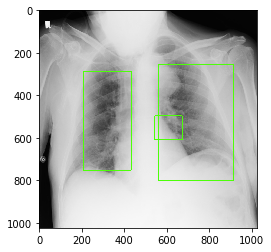

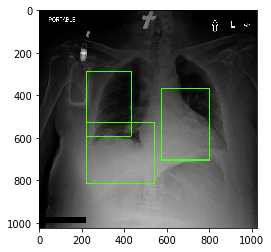

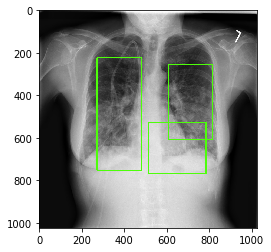

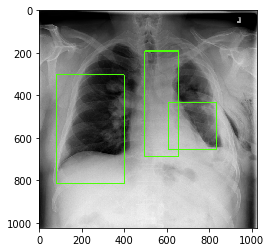

In [56]:

def visualize(): 
    session = boto3.Session()
    s3_session = session.client('s3')
    
    image_id = random.choice(image_test_fps)
    fileobj = s3_session.get_object(Bucket=root_path,  Key=image_id )
    dicom_data = fileobj['Body'].read()
    # Read DICOM
    dicom_bytes = DicomBytesIO(dicom_data)
    c_dicom = dcmread(dicom_bytes)  
    image = c_dicom.pixel_array
    
    #image_id = random.choice(test_image_fps)
    #ds = pydicom.read_file(image_id)
    
    # original image 
    #image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()
